## Nodal Interpolation for the Advection Dominated Skew to mesh

In the previous notebook on this problem, we imposed boundary conditions strongly by taking the $L^2$ projection of the boundary condition onto our test space. When the boundary condition is discontinuous, this leads to oscillations close to the discontinuity that get worse as the degree of the basis used is increased. For the advection skew to the mesh problem, these oscillations end up polluting the solution obtained. One way to avoid this fate is to impose the boundary condition by direct interpolation. This is especially powerful when used on splines because they possess the *variation diminishing property*, meaning they do not undulate more than its control polygon. Thus we end up setting a monotone boundary condition. 

## Result of $L^2$ Projection

optimize > solve > solving 101 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 101/101 dofs
optimize > optimum value 7.04e-04


<IPython.core.display.Javascript object>


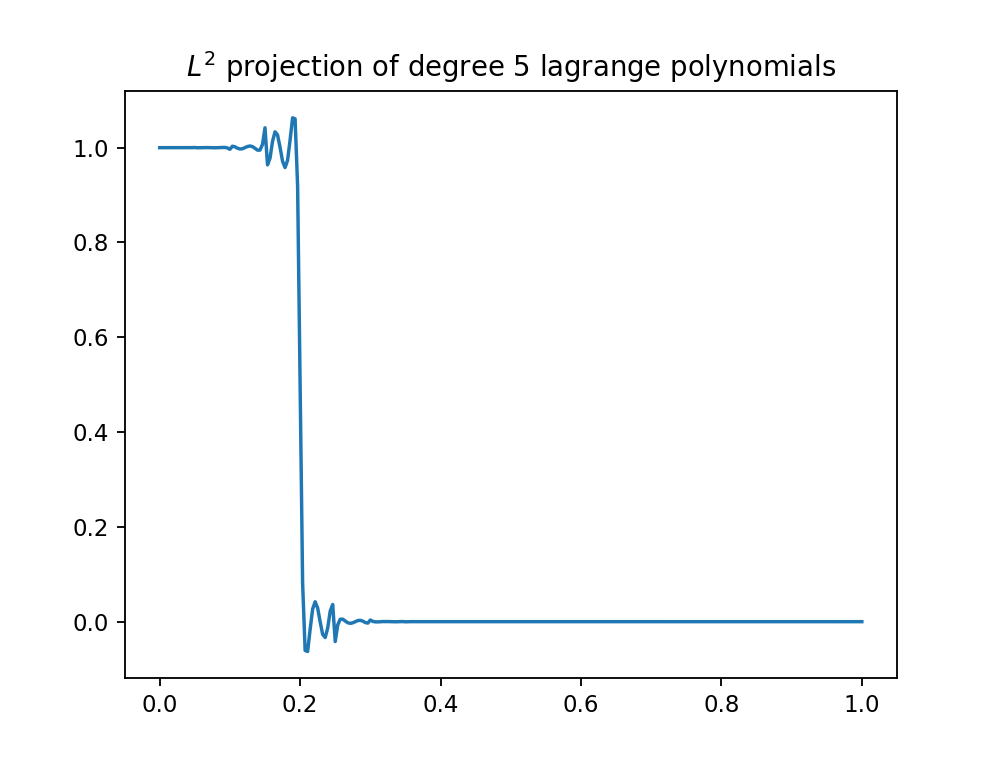

Text(0.5, 1.0, '$L^2$ projection of degree 5 lagrange polynomials')

In [30]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

degree = 5 #degree of basis functions
nelems = 20 #number of elements

topo, geom =  ntl.mesh.rectilinear([np.linspace(0,1, nelems+1)])
ns = ntl.function.Namespace()
ns.x = geom
basis_type = 'lagrange'
ns.basis = topo.basis(basis_type, degree = degree)
ns.u = 'basis_i ?dofs_i'

badbnd, badbnd2 = ntl.function.partition('x_i' @ns, .2)
ns.badbnd = badbnd[0]

sqr = topo.integral('(u - badbnd )^2 d:x' @ns, degree = degree * 2) 
cons = ntl.solver.optimize('dofs', sqr, droptol= 1e-15)

bezier = topo.sample('bezier', 15) #we plot with 15^(dimension) points per element
x = bezier.eval('x_i' @ns)
badbnd = bezier.eval('badbnd' @ns)
u = bezier.eval('u' @ns, dofs = cons )

string = r'$L^2$ projection of degree %d %s polynomials'%(degree, basis_type)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x, u)
ax.set_title(string)

To get round this we have to directly input the values of dofs in the boundary of interest. We would first have to find these dofs.  `ntl.solver.optimize` outputs a vector corresponding to the dofs and any unconstrained dofs are set to `np.nan`. We take advantage of that by placing a simple constraint on the boundary of interest, then picking out the indices of the elements that aren't `np.nan`.

optimize > constrained 24/24 dofs
optimize > optimum value 0.00e+00


<IPython.core.display.Javascript object>


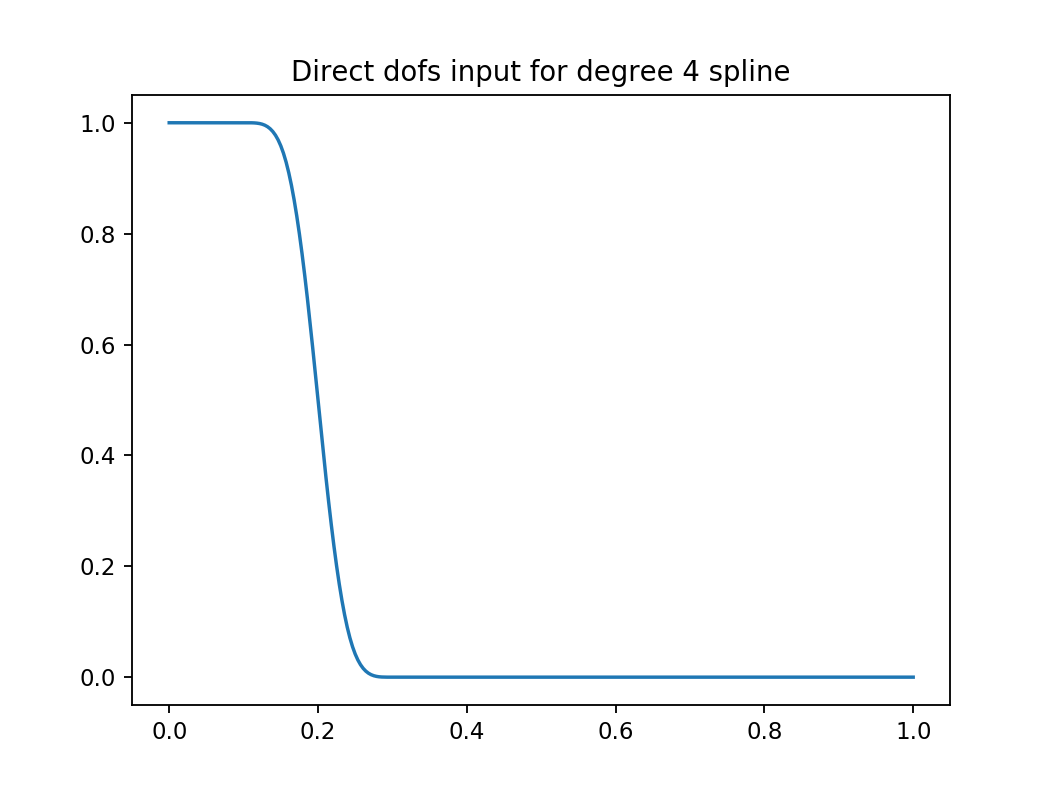

Text(0.5, 1.0, 'Direct dofs input for degree 4 spline')

In [54]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt

degree = 4 #degree of basis functions
nelems = 20 #number of elements along edge of unit square

topo, geom =  ntl.mesh.rectilinear([np.linspace(0,1, nelems+1)]) 
ns = ntl.function.Namespace()
ns.x = geom
basis_type= 'spline' 
ns.basis = topo.basis(basis_type, degree = degree)
ns.u = 'basis_i ?dofs_i'

##################################### INDEX FINDER ###############################################
def consindex(argtopo):  #outputs indices of dofs vector that need constraining
    sqr = argtopo.integral( '(u - 0)^2 d:x' @ ns,degree = degree*2 ) 
    cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #puts zeros on constrainable dofs
    consindex = np.array([])
    
    for i in range(len(cons)):
        if np.isfinite(cons[i]) == True :
            consindex = np.append(consindex, [i]) #finds zeros and notes index of occurence     
    return consindex.astype(int)
###################################################################################################

consind = consindex(topo)  #for this 1D problem, it will pick every index
cons = np.zeros(len(consind))
#Put values into selected dofs 
for i in range(int(0.2 * len(consind)) + 2):
    cons[consind[i]] = 1 
for i in range(int(.2 * len(consind)) + 2, len(consind)):
    cons[consind[i]] = 0 

bezier = topo.sample('bezier', 15) #we plot with 15^(dimension) points per element
x = bezier.eval('x_i' @ns)
u = bezier.eval('u' @ns, dofs = cons )

string = r'Direct dofs input for degree %d %s'%(degree, basis_type)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x, u)
ax.set_title(string)

## ADSM solved with SUPG and direct nodal interpolation of splines

There are two discontinuities we need to worry about: one on the left boundary and the other on the bottom right corner of the unit square. We use the procedure above to deal with both
<img src="files/advectiondominatedskewmesh.jpg">

optimize > constrained 24/576 dofs
optimize > optimum value 0.00e+00
optimize > constrained 24/576 dofs
optimize > optimum value 0.00e+00
optimize > constrained 24/576 dofs
optimize > optimum value 0.00e+00
optimize > constrained 24/576 dofs
optimize > optimum value 0.00e+00
solve > solving 484 dof system to machine precision using direct solver
solve > solver returned with residual 6e-17


<IPython.core.display.Javascript object>


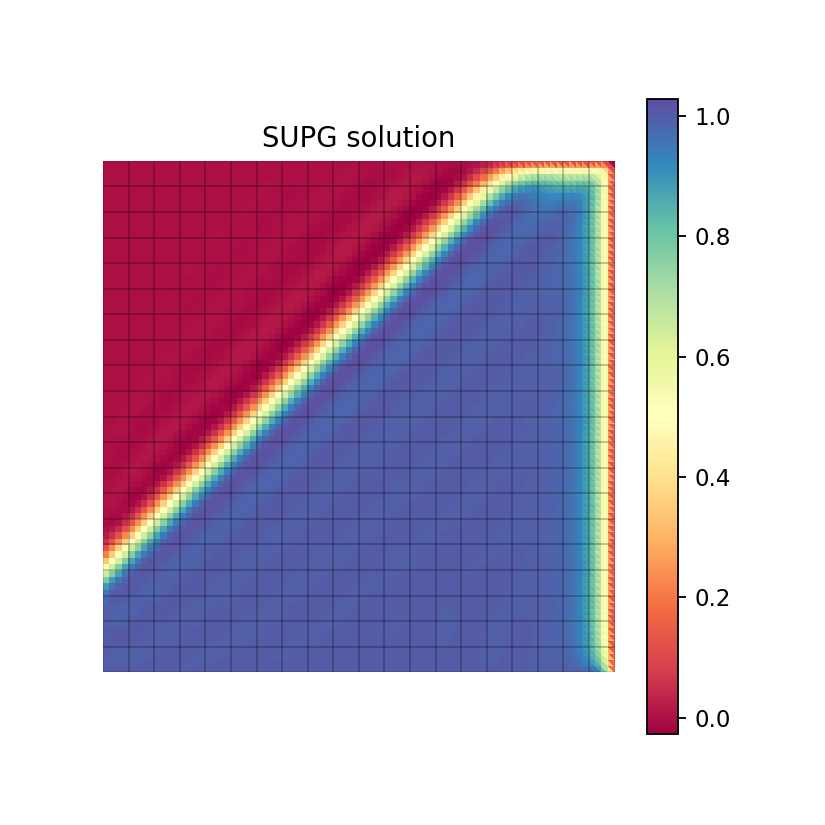

<IPython.core.display.Javascript object>


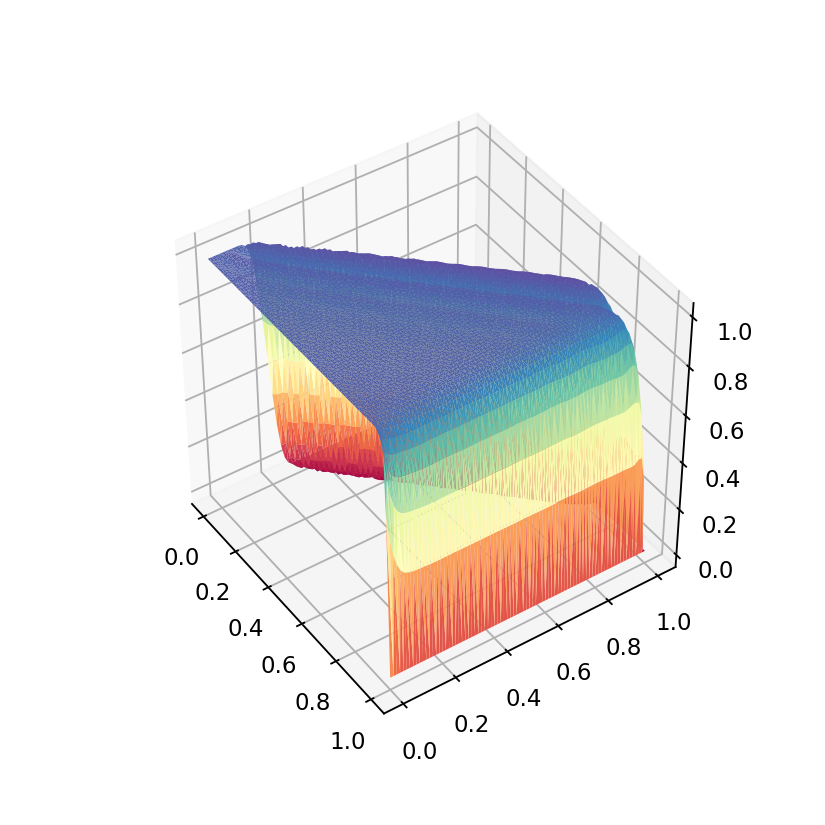

In [52]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

degree = 4 #degree of basis functions
nelems = 20 #number of elements along edge of unit square
etype = 'square' #square meshes

theta = np.pi/4
topo, geom =  ntl.mesh.unitsquare(nelems, etype) 
ns = ntl.function.Namespace()
ns.x = geom
ns.a= np.array([np.cos(theta), np.sin(theta)])
ns.kappa = 1e-6
ns.basis = topo.basis('spline', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

##################################### HELPER FUNCTION ###############################################
def consindex(argtopo):  #outputs indices of dofs vector that need constraining
    sqr = argtopo.integral( '(u - 0)^2 d:x' @ ns,degree = degree*2 ) 
    cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #puts zeros on constrainable dof
    
    consindex = np.array([])
    for i in range(len(cons)):
        if np.isfinite(cons[i]) == True :
            consindex = np.append(consindex, [i])      
    return consindex.astype(int)
###################################################################################################

#Dirichlet boundary condition

consind = consindex(topo.boundary['left']) 
consind1 = consindex(topo.boundary['bottom'])
consind2 = consindex(topo.boundary['right'])

#we'll constrain the top boundary the usual way as that presents no trouble
sqr = topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

for i in range(int(0.2 * len(consind))+2):
    cons[consind[i]] = 1 
for i in range(int(.2 * len(consind))+2, len(consind)):
    cons[consind[i]] = 0 
    
for i in range(len(consind1)):
    cons[consind1[i]] = 1
    #if i == len(consind1) - 1:
    #    cons[consind1[i]] = .5  
for i in range(len(consind2)):
    cons[consind2[i]] = 0
    #if i == len(consind2) - 1:
    #    cons[consind2[i]] = .5    
        
#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral( 'tau a_k basis_i,k (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree = degree * 2) 
lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 5)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_SUPG.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('SUPG solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

We could also try this for lagrange basis elements, but the solutions wouldn't be as crisp.